#  Import Packages

In [1]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [2]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


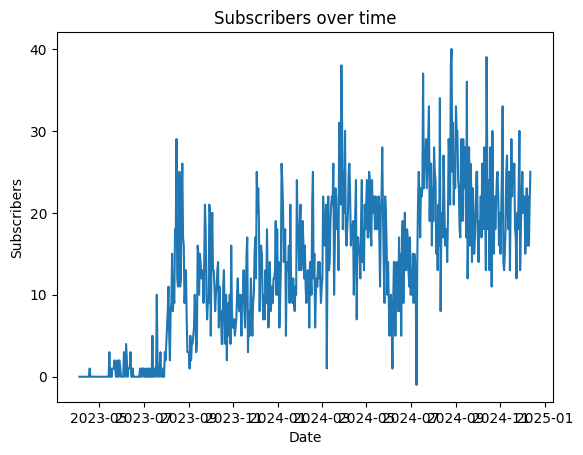

In [3]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [4]:
def prepare_train_test_data(data, time_step_in, time_step_out, test_size=0.2):
    X, Y = create_dataset(data, time_step_in, time_step_out)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    # Separate scalers for X and Y
    scaler_X = MinMaxScaler(feature_range=(0,1))
    scaler_Y = MinMaxScaler(feature_range=(0,1))
    x_train = scaler_X.fit_transform(X_train)
    y_train = scaler_Y.fit_transform(Y_train)
    x_test = scaler_X.transform(X_test)
    y_test = scaler_Y.transform(Y_test)

    print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
    
    return x_train, x_test, y_train, y_test, scaler_X, scaler_Y
x_train, x_test, y_train, y_test, scaler_X, scaler_Y = prepare_train_test_data(data, time_step_in=60, time_step_out=30, test_size=0.2)

x_train shape: (423, 60), y_train shape: (423, 30), x_test shape: (106, 60), y_test shape: (106, 30)


In [5]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (106, 60, 1)
X_train shape => (423, 60, 1)


In [6]:
lstm_model=Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(30))
lstm_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.03), metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,330 (204.41 KB)

 Trainable params: 52,330 (204.41 KB)

 Non-trainable params: 0 (0.00 B)

# Cross Validation

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = lstm_model.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = lstm_model.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
Fold 1:
  Training data size: (73, 60, 1)
  Validation data size: (70, 60, 1)
  MAE: 0.1359
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 2:
  Training data size: (143, 60, 1)
  Validation data size: (70, 60, 1)
  MAE: 0.1135
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 3:
  Training data size: (213, 60, 1)
  Validation data size: (70, 60, 1)
  MAE: 0.1140
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 4:
  Training data size: (283, 60, 1)
  Validation data size: (70, 60, 1)
  MAE: 0.1179
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 5:
  Training data size: (353, 60, 1)
  Validation data size: (70, 60, 1)
  MAE: 0.1140
------------------------------

Mean Loss (MAE) over all folds: 0.1191


In [8]:
# first sample from x_test and reshape it to (1, time_steps, features)
y_next_30 = lstm_model.predict(x_test[-1].reshape(1, x_test.shape[1], x_test.shape[2]))
y_next_30=scaler_Y.inverse_transform(y_next_30) 
y_next_30=np.round(y_next_30)
print(y_next_30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[23. 23. 23. 22. 22. 21. 21. 22. 20. 21. 23. 19. 20. 22. 19. 20. 19. 19.
  19. 20. 19. 20. 20. 20. 20. 20. 20. 19. 20. 20.]]


In [9]:
x_train= x_train.reshape(x_train.shape[0], -1)
x_test= x_test.reshape(x_test.shape[0], -1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (106, 60)
X_train shape => (423, 60)


In [10]:
x_test=scaler_X.inverse_transform(x_test)
x_train=scaler_X.inverse_transform(x_train)

In [11]:
x_test[-1]

array([14.,  9.,  5.,  9., 10.,  6.,  1.,  9., 14., 14.,  5., 11., 14.,
       10.,  8., 17.,  8., 15.,  5., 17., 19.,  9., 15., 20., 13., 13.,
       18., 17., 13., 11., 17., 10., 13., 10., 15.,  9., 15., 14., 10.,
       -1., 14., 21., 25., 22., 17., 23., 22., 23., 37., 23., 27., 26.,
       29., 23., 26., 29., 33., 19., 26., 26.])

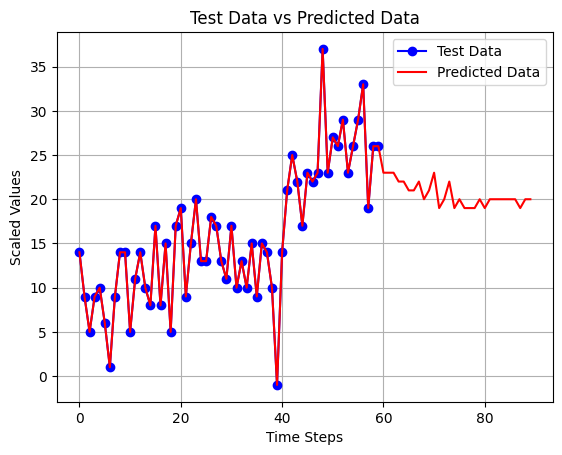

In [12]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
last_date = clean_df.index[-1]
total_sub=np.sum(clean_df["Subscribers"])
total_next_30=np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {total_next_30} => final after 30 days: {total_sub + total_next_30}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 616.0 => final after 30 days: 8733.0


In [14]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

393.3925686591276